# Used Car Prices

### Problem Statement

The aim of this project is to create regression model to help the new car trader company determine the price of used cars.

### Evaluation Metric
Mean squared error (𝑀𝑆𝐸)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
fontsize=16     # Font size of a  figure title

test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

In [2]:
print("The train dataset rows: {} , columns: {} ".format(df.shape[0],df.shape[1]))
print(df.shape)

print("The test dataset rows: {} , columns: {} ".format(df_pred.shape[0],df_pred.shape[1]))
print(df_pred.shape)

The train dataset rows: 14032 , columns: 26 
(14032, 26)
The test dataset rows: 7707 , columns: 25 
(7707, 25)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14032 entries, 0 to 14031
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  14032 non-null  object 
 1   model_name         14032 non-null  object 
 2   transmission       14032 non-null  object 
 3   color              14032 non-null  object 
 4   odometer_value     14032 non-null  int64  
 5   year_produced      14032 non-null  int64  
 6   engine_fuel        14032 non-null  object 
 7   engine_has_gas     14032 non-null  bool   
 8   engine_type        14032 non-null  object 
 9   engine_capacity    14027 non-null  float64
 10  body_type          14032 non-null  object 
 11  has_warranty       14032 non-null  bool   
 12  state              14032 non-null  object 
 13  drivetrain         14031 non-null  object 
 14  feature_0          14031 non-null  object 
 15  feature_1          14031 non-null  object 
 16  feature_2          140

## Preprocessing data

In [4]:
# Check duplicated rows
duplicated_rows = df.duplicated().sum()
print('Dataset: {}'.format(df.shape))

# Drop duplicated rows
if duplicated_rows != 0:
    df.drop_duplicates(inplace=True)
print('Dropped duplicated rows : {}'.format(duplicated_rows))
print('Dataset: {}'.format(df.shape))

Dataset: (14032, 26)
Dropped duplicated rows : 8
Dataset: (14024, 26)


In [5]:
# Find missing values 
print(f'Missing values: {df.isnull().sum().sum()}')

isnull_filter = df['price_usd'].isnull()

# Drop the row with missing price
missing_price = len(df[isnull_filter].index)
print('\nDropped rows with missing price: {} '.format(missing_price))
df.drop(df[isnull_filter].index, inplace=True)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))

Missing values: 18

Dropped rows with missing price: 1 
Dataset: (14023, 26)

Missing values: 5


### Dealing with outliers

In [6]:
# Drop electric cars
electric_cars = df['engine_type'] == 'electric'
electric = df[electric_cars]

# Remove prices over the 99.5% percentile
quantile = df['price_usd'].quantile(0.995)
price_quantile = df['price_usd'] > quantile
price = df[price_quantile]

outliers = df[(electric_cars | price_quantile )]

# Save the rows with outliers to csv file
fl = "4. Analysis/used_car_prices_outliers.csv"
outliers.to_csv(fl, index=False)

print('Dataset: {}'.format(df.shape))
df.drop( outliers.index, inplace=True)
df.reset_index(drop=True, inplace=True)
print('Dropped rows with electric cars: {} '.format(len(electric)))
print('\n0.995 quantile: {}'.format(quantile))
print('Drop prices over the 99.5% percentile: {}'.format(len(price)))
print('Dataset: {}'.format(df.shape))

Dataset: (14023, 26)
Dropped rows with electric cars: 5 

0.995 quantile: 37885.03119999992
Drop prices over the 99.5% percentile: 71
Dataset: (13948, 26)


In [7]:
# Drop extreme outliers

min_price = 100
mask_price = df['price_usd']<100

max_odometer_value = 500000
max_price = 30000
mask_odometer_value =  (df['odometer_value'] > max_odometer_value) & (df['price_usd'] > max_price)

min_year_produced = 1970
max_price = 14000
mask_produced_price = (df['year_produced'] < min_year_produced) & (df['price_usd'] > max_price)

min_year_produced = df['year_produced'].min()
mask_year_produced_min = (df['year_produced'] == min_year_produced)

min_engine_capacity = 0.8
max_engine_capacity = df['engine_capacity'].max()
mask_engine = (df['engine_capacity']<min_engine_capacity) | (df['engine_capacity'] == max_engine_capacity)

max_duration_listed = df['duration_listed'].max()
mask_duration_listed = (df['duration_listed'] == max_duration_listed)

outliers = df[(mask_price | mask_odometer_value | mask_produced_price | mask_year_produced_min | mask_engine | mask_duration_listed)]
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_extreme_outliers.csv"
outliers.to_csv(fl, index=False)

print("Dataset: {}".format(df.shape))
df.drop( outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop outliers :{}'.format(len(outliers)))
print("Dataset: {}".format(df.shape))

Dataset: (13948, 26)
Drop outliers :13
Dataset: (13935, 26)


### Feature engineering

In [8]:
# Create 'name' variable to combine manufacture and model names
columns_strip = ['manufacturer_name', 'model_name']
# Delete extra space in strings
for column in columns_strip:
    df[column] = df[column].apply(lambda x: x.strip())
# Combine manufacture and model names    
df['name'] = df['manufacturer_name'] + ' ' + df['model_name']

# Create a feature that represents mileage per year
df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
# Create a feature how old is a car
df['year'] = 2020 - df['year_produced']

# Reduce the number of car model names
# Set a limit of rare car occurrence
car_total = 6
# Count a number of car names and convert the result to a dataframe
car_models = pd.DataFrame(df['name'].value_counts())
# Get a list of rare car names
car_models = car_models[car_models['name'] < car_total].index
# create a new category'other' for rare car model names
df['name'] = df['name'].apply(lambda x: 'other' if x in car_models else x)

# Create features to reduce a number of categories
hybrid ='hybrid_or_electric'
df['engine_fuel'] = df['engine_fuel'].replace({'hybrid-petrol':hybrid,'hybrid-diesel':hybrid,'electric':hybrid})


# Create a list of unnamed features
features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
# Count a total number of unnamed features for a car
df['other_features']=df[features_list].sum(axis=1)

# Round car prices
df['price_usd'] = df['price_usd'].apply(lambda x: round(x,-2))

### Feature selection

In [9]:
df.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'feature_9', 'duration_listed', 'price_usd', 'name',
       'odometer_value/year', 'year', 'other_features'],
      dtype='object')

In [10]:
# Define predictor and target variables
features =[ 'manufacturer_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 'name',
           'odometer_value', 'odometer_value/year', 'year',  'engine_fuel','color',
           'duration_listed', 'body_type', 'engine_capacity', 'other_features', 'feature_0',
           
           #'year_produced', 'engine_type','color', 'engine_fuel'
           #'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
           #'feature_6', 'feature_7', 'feature_8', 'feature_9'           
           ]

target = 'price_usd'

# Create the dataset to fit a model
data = df[features+ [target]].copy()
print('Dataset: {}'.format(data.shape))

Dataset: (13935, 17)


## Model

### Create pipeline

In [11]:
# Copy the initial dataset before transformation
df_origin = data.copy()

# Create features and target from the data set
X = data.drop(target ,axis=1)
y = data[target]

# Numeric data types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Print numeric features
numeric_features = X.select_dtypes(numerics).columns.tolist()
print('Numeric features: {}'.format(numeric_features))


# Applies Power Transformer using Yeo-Johnson transformation to numeric columns 
numeric_power = ['odometer_value',  'odometer_value/year', 'duration_listed']

numeric_power_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('power', PowerTransformer(method='yeo-johnson')),
                                     ('scaler', StandardScaler())
                                    ])

# Applies Quantile Transformer to numeric columns 
numeric_quantile = ['engine_capacity', 'year', 'other_features']

numeric_quantile_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('quantile', QuantileTransformer(n_quantiles=100, output_distribution='normal')),
                                     ('scaler', StandardScaler())
                                    ])


# Print categorical features
categorical_features = X.select_dtypes([np.object,np.bool]).columns.tolist()
print('Categorical features: {}'.format(categorical_features))

# Transform categorical columns using OneHotEncoder
categorical_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                     ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])
# Create ColumnTransformer to perform different transformations for different columns of the data
preprocessor = ColumnTransformer(transformers=
                                 [('num_power', numeric_power_transformer, numeric_power),
                                  ('num_qt', numeric_quantile_transformer, numeric_quantile),
                                  ('cat', categorical_transformer, categorical_features)
                                 ])

# Reshape target variable
y = np.array(y).reshape(-1,1)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Transform the target variable
power_tr = PowerTransformer(method='yeo-johnson')
power_tr.fit(y_train)

y_train = power_tr.transform(y_train)
y_test = power_tr.transform(y_test)

Numeric features: ['odometer_value', 'odometer_value/year', 'year', 'duration_listed', 'engine_capacity', 'other_features']
Categorical features: ['manufacturer_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 'name', 'engine_fuel', 'color', 'body_type', 'feature_0']


### Model

In [12]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR(C=1)
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()
y_test = y_test.ravel()

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))


SVR(C=1)
Score: 0.9184250066696926
MSE: -0.09287482056193627


In [13]:
# As the target variable was transformed, aplly inverse transformation to get car price in dollars
y_predict_test_price = power_tr.inverse_transform(y_predict_test.reshape(-1,1))
# Round car prices to hundred
y_predict_test_price_round = np.round(y_predict_test_price,-2)
results = pd.DataFrame( {'Actual transformed':y_test.reshape(-1), 'Predicted':y_predict_test.reshape(-1),
                         'Predicted inverse transformed':y_predict_test_price.reshape(-1), 
                         'Predicted inverse transformed rounded':y_predict_test_price_round.reshape(-1)},
                       index=X_test.index)

# Combine the results in a dataframe
results = results.join(df_origin['price_usd'], how ='left')
results.rename(columns={'price_usd':'Actual'}, inplace=True)

print('Car Prices')
results.head(10)

Car Prices


,Actual transformed,Predicted,Predicted inverse transformed,Predicted inverse transformed rounded,Actual
5847,-1.886673,-1.626292,721.899196,700.0,500.0
4639,-0.250611,0.028444,4736.392801,4700.0,3600.0
8369,-0.024726,-0.392705,3113.162937,3100.0,4500.0
1819,-0.336169,-0.418382,3031.196495,3000.0,3300.0
10525,-1.759664,-2.026276,406.144398,400.0,600.0
1087,0.126742,0.341212,6340.248846,6300.0,5200.0
8078,0.947012,0.908034,10361.216265,10400.0,10700.0
10352,-0.493981,-0.670729,2314.981160,2300.0,2800.0
4432,-0.996509,-0.969858,1650.701173,1700.0,1600.0
7485,0.804067,0.747441,9056.019375,9100.0,9500.0


In [14]:
results.tail(10)

,Actual transformed,Predicted,Predicted inverse transformed,Predicted inverse transformed rounded,Actual
9760,-0.460682,-0.714931,2205.057212,2200.0,2900.0
11539,2.092654,1.460680,16072.651526,16100.0,25500.0
7193,0.865317,0.773582,9258.834621,9300.0,10000.0
4306,0.042381,-0.041705,4426.565202,4400.0,4800.0
6847,-0.250611,-0.244105,3623.686793,3600.0,3600.0
5295,-0.944576,-1.001962,1589.783454,1600.0,1700.0
13072,0.280744,0.309696,6161.006736,6200.0,6000.0
13004,-1.304726,-1.863620,517.065170,500.0,1100.0
13069,-1.461106,-1.485311,871.877405,900.0,900.0
5903,0.186614,0.726527,8896.370619,8900.0,5500.0


In [15]:
# Find out mean squared error
mse = mean_squared_error(results['Actual'], results['Predicted inverse transformed'])
print('MSE: {}'.format(mse))

MSE: 2839283.9273817204


Text(0.5, 0, 'Car Price')

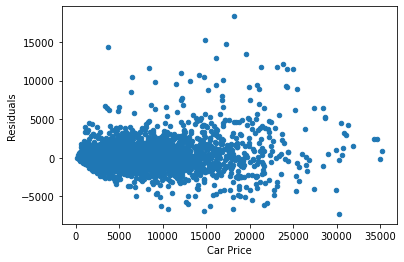

In [16]:
# Plot residuals
results['Residuals'] = results['Actual'] - results['Predicted inverse transformed']
results.plot(x = 'Predicted inverse transformed', y = 'Residuals',kind = 'scatter')
plt.xlabel('Car Price')

In [17]:
# Save the pipeline
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(pipe, f)

print('The file {} is saved.'.format(model_path))

# Save the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'wb') as f:
    pickle.dump(power_tr, f)
print('The file {} is saved.'.format(transformer_path))

The file 5. Insights/Models/used_car_prices_model.pickle is saved.
The file 5. Insights/Models/used_car_prices_target_transformation.pickle is saved.


## Ptrediction 

In [18]:
# Load the data
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(prediction_data)

# Load a model from a file
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'rb') as f:
    regression_model_loaded = pickle.load(f)
print('Regression model {} is loaded.'.format(regression_model_loaded))

# Load the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'rb') as f:
    transformer_loaded = pickle.load(f)
print('Transformer {} is loaded.'.format(transformer_loaded))

Regression model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_power',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer_value',
                                                   'odometer_value/year',
                                                   'duration_listed']),
                                                 ('num_qt',
      

### Preprocess the data

In [19]:
# Create 'name' variable to combine manufacture and model names
columns_strip = ['manufacturer_name', 'model_name']
# Delete extra space in strings
for column in columns_strip:
    df[column] = df[column].apply(lambda x: x.strip())
# Combine manufacture and model names    
df['name'] = df['manufacturer_name'] + ' ' + df['model_name']

# Create a feature that represents mileage per year
df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
# Create a feature how old is a car
df['year'] = 2020 - df['year_produced']

# Reduce the number of car model names
# Set a limit of rare car occurrence
car_total = 6
# Count a number of car names and convert the result to a dataframe
car_models = pd.DataFrame(df['name'].value_counts())
# Get a list of rare car names
car_models = car_models[car_models['name'] < car_total].index
# create a new category'other' for rare car model names
df['name'] = df['name'].apply(lambda x: 'other' if x in car_models else x)

# Create features to reduce a number of categories
hybrid ='hybrid_or_electric'
df['engine_fuel'] = df['engine_fuel'].replace({'hybrid-petrol':hybrid,'hybrid-diesel':hybrid,'electric':hybrid})

# Create a list of unnamed features
features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
# Count a total number of unnamed features for a car
df['other_features']=df[features_list].sum(axis=1)

# Define predictor variables
features =[ 'manufacturer_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 'name',
           'odometer_value', 'odometer_value/year', 'year',  'engine_fuel','color',
           'duration_listed', 'body_type', 'engine_capacity', 'other_features', 'feature_0',
           ]

### Prediction of car prices

In [20]:
# Make prediction using the pipeline
prediction = regression_model_loaded.predict(df[features])
prediction

array([-0.98057763, -0.79509045, -0.0357562 , ..., -0.36707498,
        1.38403971, -0.71307949])

In [21]:
# Transform predicted price to get the rounded car price in dollars
y_predict_price = transformer_loaded.inverse_transform(prediction.reshape(-1,1))
# Round car price to hundred
y_predict_price_round = np.round(y_predict_price,-2)
# Create a dataframe with results
results = pd.DataFrame( {'Predicted':y_predict_price.reshape(-1),
                         'Predicted rounded':y_predict_price_round.reshape(-1)},
                          index=df.index)

# Form a dataframe with car information and predicted prices
prediction_results = df.join(results)

# Save car information and predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_prediction_data_predicted_price.csv"
prediction_results.to_csv(fl, index=False)

# Save predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_predicted_price.csv"
results.to_csv(fl, index=False)

# Predicted car prices
results

,Predicted,Predicted rounded
0,1630.153931,1600.0
1,2016.545408,2000.0
2,4452.182328,4500.0
3,10044.839076,10000.0
4,5509.451315,5500.0
...,...,...
7702,2574.606131,2600.0
7703,17271.026202,17300.0
7704,3196.767203,3200.0
7705,15155.154055,15200.0
